In [119]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial import Delaunay

## Define Functions

In [120]:
# Helper function to rotate feature kernel
def rotate_point(origin, point, angle):

    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)

    return int(qx), int(qy)

# Node detection kernel, generates feature to detect inside sliding window
def node_detect(win, feature="elbow", angle=0, thickness=1):

    # Check that feature is correctly specified
    assert feature in ("cross", "tee", "elbow", "end"), "Feature must be in {'cross', 'tee', 'elbow', 'end'}"

    # Convert angle to radians
    angle = np.deg2rad(angle)
    
    # Create kernel matrix 
    kernel = np.zeros((win, win), np.uint8)

    center = win // 2
    origin = (center, center)

    # Top
    if feature in ("cross", "tee", "elbow", "end"):
        endpoint = rotate_point(origin, (center, -10), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)
    # Bottom
    if feature == "cross":
        endpoint = rotate_point(origin, (center, win+10), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)
    # Left 
    if feature in ("cross", "tee"):
        endpoint = rotate_point(origin, (-10, center), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)
    # Right 
    if feature in ("cross", "tee", "elbow"):
        endpoint = rotate_point(origin, (win+10, center), angle)
        cv2.line(kernel, origin, endpoint, (1, 1, 1), thickness)

    return kernel

# Sliding window traverses image and checks for features
def find_vertices(img, kernel, stride):

    # Make sure kernel has a center point
    assert kernel % 2 != 0, "Window size must be odd."

    # If image isn't grayscale, convert
    if len(img.shape) != 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        
    # Threshold image
    _, img = cv2.threshold(img, 5, 255, cv2.THRESH_BINARY)
    img = img//255

    # Pad image to be divisible by stride
    while img.shape[0] % stride != 0:
        img = cv2.copyMakeBorder(img, 0, 1, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    while img.shape[1] % stride != 0:
        img = cv2.copyMakeBorder(img, 0, 0, 0, 1, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Padding for sliding window
    pad = int(kernel//2)+1
    img = cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    img_copy = img.copy() # Copy padded image for output

    #Compute total strides
    x_strides = int(img.shape[1]/stride) - 2*pad
    y_strides = int(img.shape[0]/stride) - 2*pad
    print(f"x strides:{x_strides}, y strides:{y_strides}")

    # Initialize variables
    knots = []
    ends = []
    win_x_beg = 0
    win_y_beg = 0
    win_x_end = kernel
    win_y_end = kernel

    for ii in range(x_strides):
        for jj in range(y_strides):

            # Define current window
            cur_window = img[win_x_beg:win_x_end, win_y_beg:win_y_end]

            # Only look in windows that aren't black, and aren't too white
            if np.sum(cur_window) > 0 and np.mean(cur_window) < .5:
                
                # If window qualifies, rotate the search feature and check if it is present.
                for theta in range(0,360,10):
                    feature = node_detect(kernel, feature="tee", angle=theta, thickness=1)
                    if np.array_equal((feature*cur_window), feature):
                        knots.append((win_y_beg+pad, win_x_beg+pad))
                        # If feature is found, black out window as a debounce
                        img[win_x_beg:win_x_end, win_y_beg:win_y_end] = 0
                        break
            
            # Increment row
            win_y_beg += stride
            win_y_end += stride
        
        # Increment column
        win_x_beg += stride
        win_x_end += stride

        # Reset row values
        win_y_beg = 0
        win_y_end = kernel

    return img_copy, knots, ends

## Analyze Single Image

In [121]:
# Load image to analyze
src = cv2.imread('test_sequence/image2.png', cv2.IMREAD_GRAYSCALE)

In [122]:
# Sliding window parameters
window = 27
stride = 2

In [123]:
# Find vertices in image
resized_img, vertices, ends = find_vertices(src, window, stride)
print(f"image size: {resized_img.shape}")
print(f"vertices detected: {len(vertices)}")

x strides:1007, y strides:1008
image size: (2072, 2070)
vertices detected: 66


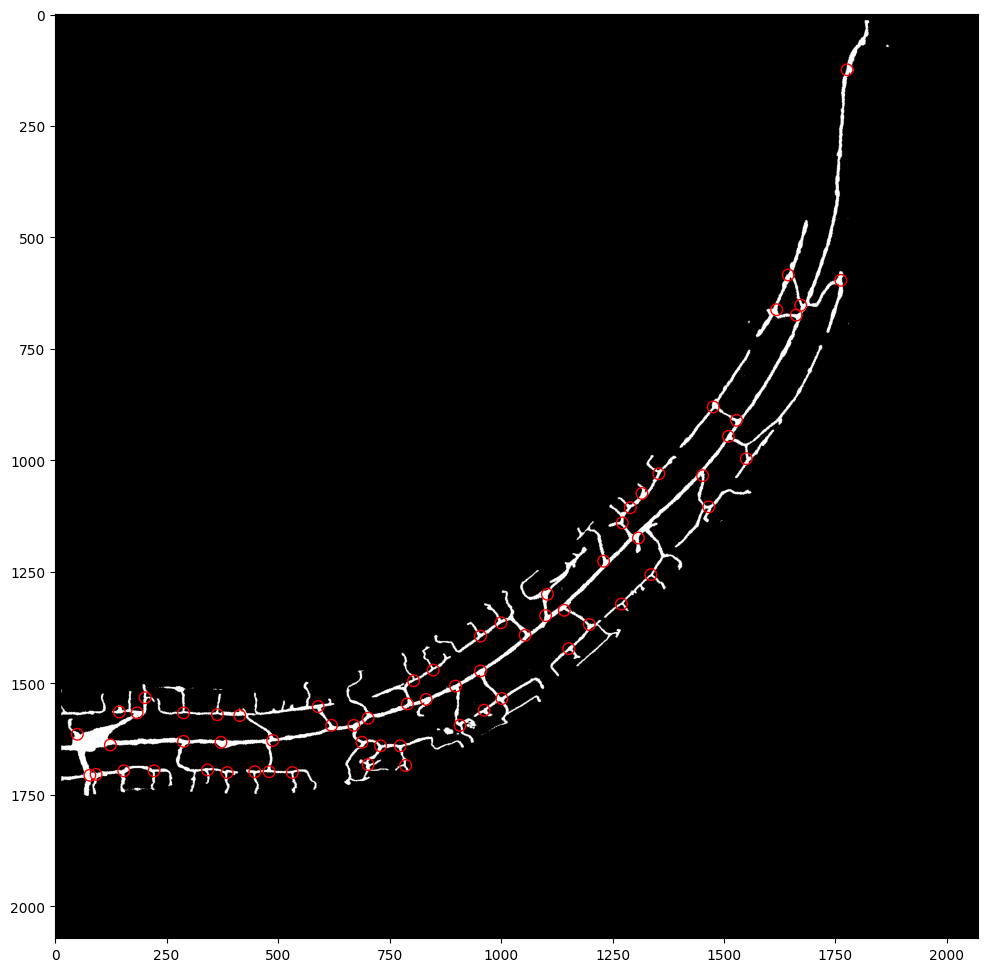

In [124]:
# Plot Vertices on image
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(resized_img, cmap='gray')
#ax.scatter(*zip(*vertices), s=25, c='r', alpha=0.5)

# Adding circles at each knot
for xi, yi in vertices:
    circle = Circle((xi, yi), radius=(window//2), fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(circle)

# Adding circles at each end
for xi, yi in ends:
    circle = Circle((xi, yi), radius=(window//2), fill=False, edgecolor='blue', linewidth=1)
    ax.add_patch(circle)

In [125]:
# Try making border points to see how they are used in Delaunay
# width = resized_img.shape[0]

# for ii in range(0, width, width//16):
#     knots.append()

In [126]:
delaunay = Delaunay(vertices)
knots = np.array(vertices)

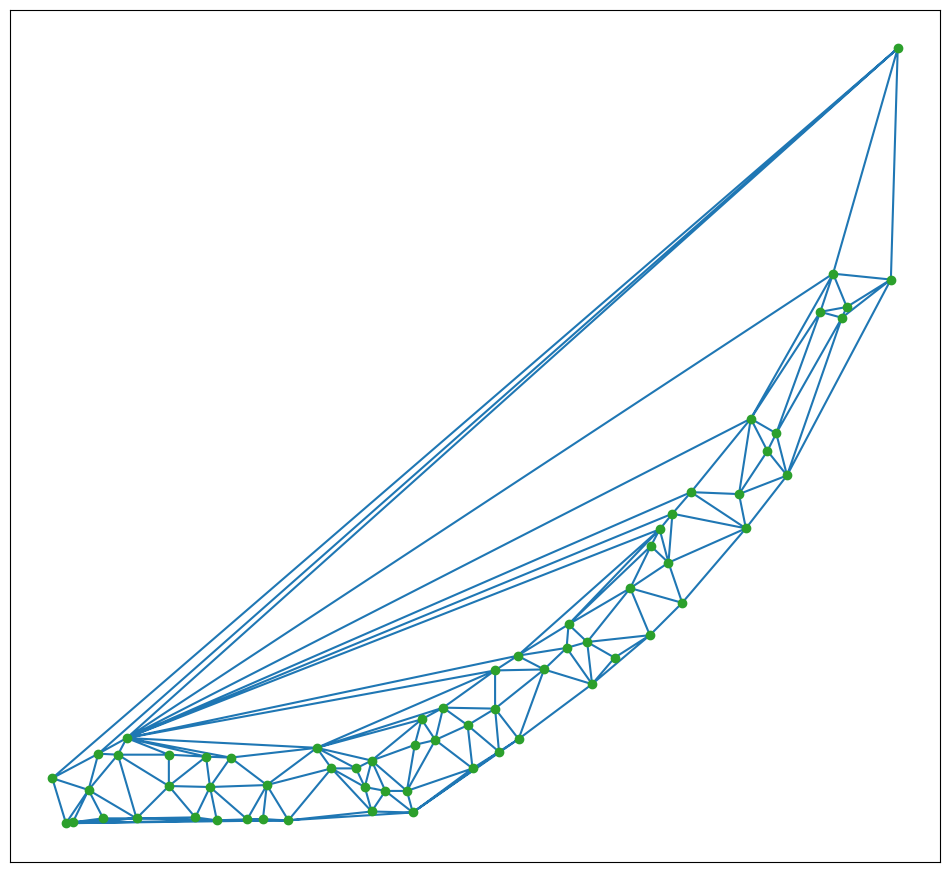

In [127]:
plt.figure(figsize=(12, 12))
plt.triplot(knots[:, 0], -knots[:, 1], delaunay.simplices)
plt.plot(knots[:, 0], -knots[:, 1], 'o')

plt.gca().set_aspect('equal', adjustable='box')
plt.xticks([])
plt.yticks([])

plt.show()